### Import Library

In [1]:
# !pip install pandas numpy scikit-learn xgboost imbalanced-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, f1_score, 
                             precision_score, recall_score)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

### Load Dataset

In [2]:
train = pd.read_csv("C:/Users/muham/OneDrive/Documents/KULIAH SEMESTER 7/MACHINE LEARNING/UTS/train_transaction.csv")
test = pd.read_csv("C:/Users/muham/OneDrive/Documents/KULIAH SEMESTER 7/MACHINE LEARNING/UTS/test_transaction.csv")

print(f"Data loaded successfully!")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

print("\nFirst 5 rows:")
display(train.head())

print("\nDataset Info:")
print(f"Total rows: {len(train):,}")
print(f"Total columns: {train.shape[1]}")

Data loaded successfully!
Train shape: (590540, 394)
Test shape: (506691, 393)

First 5 rows:


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Dataset Info:
Total rows: 590,540
Total columns: 394


### Target Distribution


Class Distribution:
Normal (0): 569,877 (96.50%)
Fraud (1): 20,663 (3.50%)

Imbalance Ratio: 27.6:1


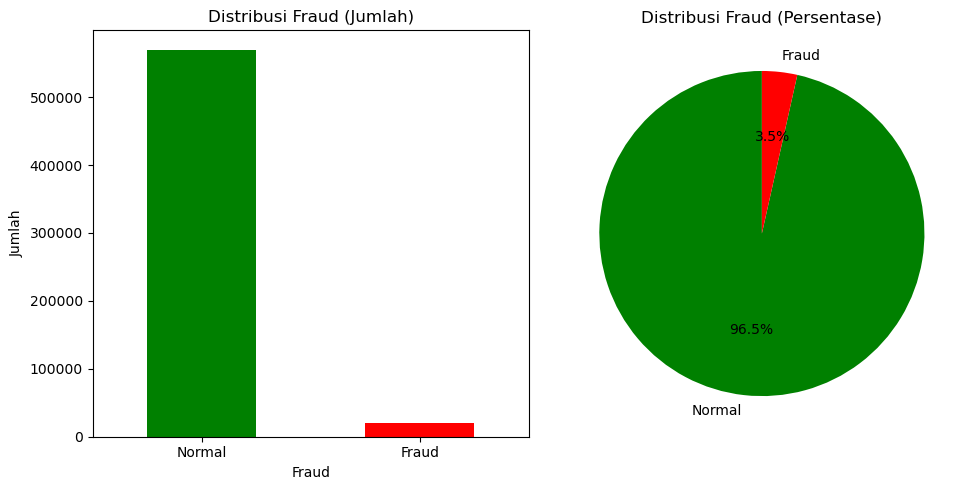

In [3]:
fraud_counts = train['isFraud'].value_counts()
fraud_pct = train['isFraud'].value_counts(normalize=True) * 100

print(f"\nClass Distribution:")
print(f"Normal (0): {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"Fraud (1): {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: {fraud_counts[0]/fraud_counts[1]:.1f}:1")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
fraud_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribusi Fraud (Jumlah)')
plt.xlabel('Fraud')
plt.ylabel('Jumlah')
plt.xticks([0, 1], ['Normal', 'Fraud'], rotation=0)

plt.subplot(1, 2, 2)
plt.pie(fraud_counts, labels=['Normal', 'Fraud'], autopct='%1.1f%%', 
        colors=['green', 'red'], startangle=90)
plt.title('Distribusi Fraud (Persentase)')

plt.tight_layout()
plt.show()

> Code Block ini digunakan untuk menganalisis distribusi target variable apakah fraud atau normal.

### EDA


Columns with missing values: 374 / 394

Top 15 columns with most missing values:


,Column,Missing_Count,Percentage
14,dist2,552913,93.628374
37,D7,551623,93.409930
43,D13,528588,89.509263
44,D14,528353,89.469469
42,D12,525823,89.041047
36,D6,517353,87.606767
39,D9,515614,87.312290
38,D8,515614,87.312290
211,V157,508595,86.123717
217,V163,508595,86.123717


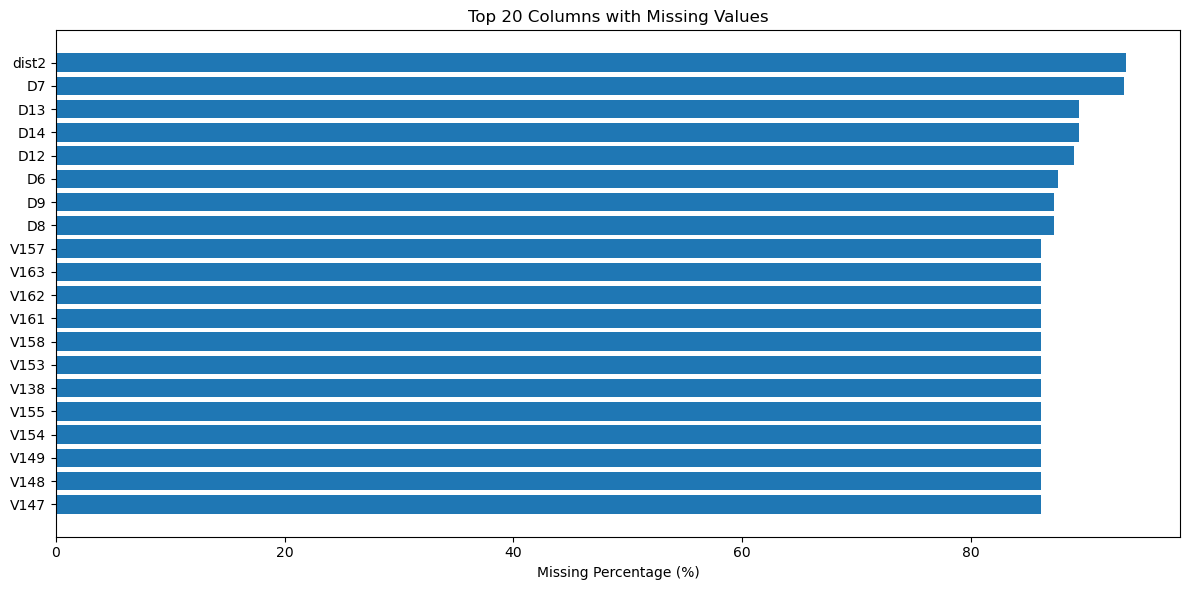


Data Types Distribution:
float64    376
object      14
int64        4
Name: count, dtype: int64

Numeric columns: 380
Categorical columns: 14

Categorical columns list:
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


In [4]:
# Missing Value
missing = train.isnull().sum()
missing_pct = (missing / len(train)) * 100

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Percentage', ascending=False)

print(f"\nColumns with missing values: {len(missing_df)} / {train.shape[1]}")
print(f"\nTop 15 columns with most missing values:")
display(missing_df.head(15))

# Visualisasi
if len(missing_df) > 0:
    plt.figure(figsize=(12, 6))
    top_missing = missing_df.head(20)
    plt.barh(range(len(top_missing)), top_missing['Percentage'])
    plt.yticks(range(len(top_missing)), top_missing['Column'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 20 Columns with Missing Values')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Tipe Data
dtype_counts = train.dtypes.value_counts()
print("\nData Types Distribution:")
print(dtype_counts)

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

if len(categorical_cols) > 0:
    print(f"\nCategorical columns list:")
    print(categorical_cols)

> Code Block diatas berfungsi untuk menghitung seberapa banyak nilai yang **missing** atau hilang di setiap kolom. Tujuan dari menghitung banyaknya nilai yang hilang adalah untuk membersihkan dataset agar dapat diolah.

In [5]:
# Feature-Target Split
train_id = train['TransactionID'].copy()
test_id = test['TransactionID'].copy()
y = train['isFraud'].copy()

train_features = train.drop(['TransactionID', 'isFraud'], axis=1)
test_features = test.drop(['TransactionID'], axis=1)

print(f"Features shape: {train_features.shape}")
print(f"Target shape: {y.shape}")

Features shape: (590540, 392)
Target shape: (590540,)


> Feature-Target Split digunakan untuk memisahkan dataset menjadi komponen-komponen yang berbeda sesuai fungsinya.

In [6]:
# Handle Missing Values (Hapus kolom dengan > 90% missing)
missing_threshold = 0.9  # 90% missing
missing_pct = train_features.isnull().sum() / len(train_features)
cols_to_drop = missing_pct[missing_pct > missing_threshold].index.tolist()

print(f"\nDropping {len(cols_to_drop)} columns with > {missing_threshold*100}% missing")
print(f"Columns dropped: {cols_to_drop[:10]}..." if len(cols_to_drop) > 10 else f"Columns dropped: {cols_to_drop}")

train_features = train_features.drop(columns=cols_to_drop)
test_features = test_features.drop(columns=cols_to_drop, errors='ignore')

print(f"\nNew shape: {train_features.shape}")


Dropping 2 columns with > 90.0% missing
Columns dropped: ['dist2', 'D7']

New shape: (590540, 390)


> Code Block ini berfungsi untuk menghapus kolom yang memiliki persentasi missing sangat tinggi (>90%). Karena rasionalnya kolom yang memiliki missing 90% tidak akan berguna karena tidak memberikan banyak informasi. Selain itu kolom yang memiliki missing tinggi jika diisi dengan suatu nilai dikhawatirkan akan mengganggu kestabilan data

In [7]:
# Mengisi missing numeric dengan median
numeric_cols = train_features.select_dtypes(include=[np.number]).columns.tolist()
print(f"Processing {len(numeric_cols)} numeric columns...")

for col in numeric_cols:
    if train_features[col].isnull().sum() > 0:
        median_val = train_features[col].median()
        train_features[col].fillna(median_val, inplace=True)
        if col in test_features.columns:
            test_features[col].fillna(median_val, inplace=True)

print(f"Numeric missing values filled with median")
print(f"Remaining missing in train: {train_features[numeric_cols].isnull().sum().sum()}")

# Mengisi missing categorical dengan 'Unknown'
categorical_cols = train_features.select_dtypes(include=['object']).columns.tolist()
print(f"Processing {len(categorical_cols)} categorical columns...")

for col in categorical_cols:
    train_features[col].fillna('Unknown', inplace=True)
    if col in test_features.columns:
        test_features[col].fillna('Unknown', inplace=True)

print(f"Categorical missing values filled with 'Unknown'")

Processing 376 numeric columns...
Numeric missing values filled with median
Remaining missing in train: 0
Processing 14 categorical columns...
Categorical missing values filled with 'Unknown'


> Code Block ini berfungsi untuk mengisi cell yang tidak ada nilainya. Median dipilih karena lebih tahan terhadap outlier, selain itu jika digunakan mean, terkadang ada transaksi dengan nilai ekstrem yang bisa membuat nilai mean menjadi misleading.

### Label Encoding

In [ ]:
categorical_cols = train_features.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

print(f"Encoding {len(categorical_cols)} categorical columns...")

for col in categorical_cols:
    le = LabelEncoder()
    
    combined = pd.concat([train_features[col], test_features[col]], axis=0)
    le.fit(combined.astype(str))
    
    train_features[col] = le.transform(train_features[col].astype(str))
    test_features[col] = le.transform(test_features[col].astype(str))
    label_encoders[col] = le

print(f"All categorical variables encoded")
print(f"Final train shape: {train_features.shape}")
print(f"Final test shape: {test_features.shape}")

Encoding 14 categorical columns...
All categorical variables encoded
Final train shape: (590540, 390)
Final test shape: (506691, 390)


> Code Block ini berfungsi untuk mengkonversi semua categorical variable menjadi numerical variable. Perlu di konversi karena XGBoost dan Random Forest membutuhkan input numerical. Sehingga, dataset yang akan diolah sudah sepenuhnya numerical yang sebelumnya ada yang berupa categorical (Visa, Mastercard, dll).

### Feature Engineering

In [9]:
# Transaction Amount
if 'TransactionAmt' in train_features.columns:
    train_features['TransactionAmt_log'] = np.log1p(train_features['TransactionAmt'])
    test_features['TransactionAmt_log'] = np.log1p(test_features['TransactionAmt'])

    train_features['TransactionAmt_decimal'] = train_features['TransactionAmt'] - train_features['TransactionAmt'].astype(int)
    test_features['TransactionAmt_decimal'] = test_features['TransactionAmt'] - test_features['TransactionAmt'].astype(int)

    train_features['is_round_amount'] = (train_features['TransactionAmt'] % 100 == 0).astype(int)
    test_features['is_round_amount'] = (test_features['TransactionAmt'] % 100 == 0).astype(int)
    
    print("Created 3 TransactionAmt features")
else:
    print("TransactionAmt column not found")

Created 3 TransactionAmt features


> Code Block diatas berfungsi untuk dilakukan feature engineering pada TransactionAmt untuk extract informasi tambahan yang mungkin akan berguna untuk pengolahan (fraud detection). Dibuat 3 ekstraksi fitur: 1. log transformation = membuat distribusinya lebih normal untuk dipelajari model, karena distribusi transaction amount biasanya right-skewed dengan outliers . 2. Mengekstrak menjadi nilai desimal dari amount (misalnya dari $123.45 menjadi 0.45). Bertujuan untuk mendeteksi fraud yang memiliki pola desimal yang berbeda. 3. Membuat binary feature

In [10]:
# Transaction Time Features
if 'TransactionDT' in train_features.columns:
    # Day of transaction
    train_features['TransactionDT_day'] = train_features['TransactionDT'] // (24 * 3600)
    test_features['TransactionDT_day'] = test_features['TransactionDT'] // (24 * 3600)
    
    # Hour of transaction
    train_features['TransactionDT_hour'] = (train_features['TransactionDT'] % (24 * 3600)) // 3600
    test_features['TransactionDT_hour'] = (test_features['TransactionDT'] % (24 * 3600)) // 3600
    
    # Is night time (suspicious)
    train_features['is_night'] = ((train_features['TransactionDT_hour'] >= 0) & 
                                   (train_features['TransactionDT_hour'] <= 6)).astype(int)
    test_features['is_night'] = ((test_features['TransactionDT_hour'] >= 0) & 
                                  (test_features['TransactionDT_hour'] <= 6)).astype(int)
    
    # Is weekend
    train_features['is_weekend'] = (train_features['TransactionDT_day'] % 7 >= 5).astype(int)
    test_features['is_weekend'] = (test_features['TransactionDT_day'] % 7 >= 5).astype(int)
    
    print("Created 5 time-based features")
else:
    print("TransactionDT column not found")

print(f"\nTotal features after engineering: {train_features.shape[1]}")

Created 5 time-based features

Total features after engineering: 397


> Ekstraksi feature pada bagian waktu transaksi untuk extract temporal patterns yang sangat relevan untuk fraud detection. Dibuat 4 ekstraksi tambahan: 1. Ekstraksi harian. 2. Ekstrasi jam. 3. Ekstraksi "is_night" untuk mendeteksi transaksi yang terjadi antara 12 AM hingga 6 AM. 4. Ekstraksi "is_weekend" untuk mendeteksi transaksi yang terjadi di Sabtu-Minggu.

### Check Final Data

In [11]:
print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Target shape: {y.shape}")

print(f"\nMissing values in train: {train_features.isnull().sum().sum()}")
print(f"Missing values in test: {test_features.isnull().sum().sum()}")

print(f"\nData types:")
print(train_features.dtypes.value_counts())

Train features shape: (590540, 397)
Test features shape: (506691, 397)
Target shape: (590540,)

Missing values in train: 0
Missing values in test: 4787

Data types:
float64    376
int32       17
int64        4
Name: count, dtype: int64


> Code Block diatas berfungsi untuk mengecek kembali dataset yang sebelumnya sudah dilakukan Data Cleaning dan Ekstraksi Fitur. Tujuannya agar dataset tersebut benar benar sudah siap untuk diolah menjadi model.

### Handle Imbalance (SMOTE)

Original distribution:
Normal: 569,877
Fraud: 20,663
Fraud rate: 3.50%

After SMOTE:
Normal: 569,877
Fraud: 170,963
Fraud rate: 23.08%


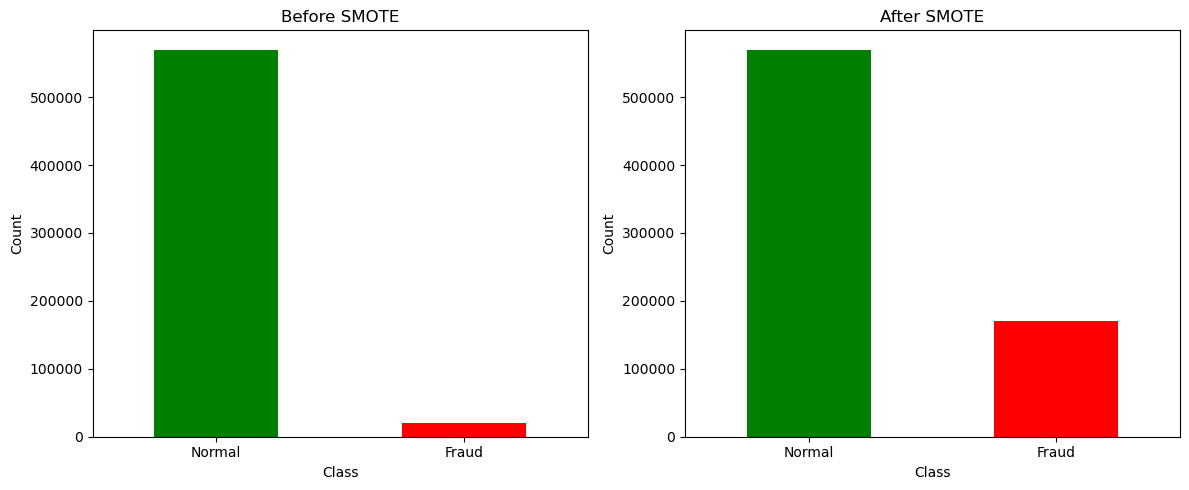

In [12]:
print(f"Original distribution:")
print(f"Normal: {(y==0).sum():,}")
print(f"Fraud: {(y==1).sum():,}")
print(f"Fraud rate: {(y==1).sum() / len(y) * 100:.2f}%")

# Apply SMOTE
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_resampled, y_resampled = smote.fit_resample(train_features, y)

print(f"\nAfter SMOTE:")
print(f"Normal: {(y_resampled==0).sum():,}")
print(f"Fraud: {(y_resampled==1).sum():,}")
print(f"Fraud rate: {(y_resampled==1).sum() / len(y_resampled) * 100:.2f}%")

# Visualisasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
pd.Series(y).value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal', 'Fraud'], rotation=0)

plt.subplot(1, 2, 2)
pd.Series(y_resampled).value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal', 'Fraud'], rotation=0)

plt.tight_layout()
plt.show()

> SMOTE (Synthetic Minority Over-Sampling Technique) digunakan untuk mengatasi severe class imbalance yang sudah teridentifikasi diawal. 

### Data Splitting

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

print(f"Data split successfully!")
print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

print(f"\nTraining fraud rate: {(y_train==1).sum() / len(y_train) * 100:.1f}%")
print(f"Validation fraud rate: {(y_val==1).sum() / len(y_val) * 100:.1f}%")

Data split successfully!

Training set: (592672, 397)
Validation set: (148168, 397)

Training fraud rate: 23.1%
Validation fraud rate: 23.1%


> Code Block ini berfungsi untuk membagi data yang sudah di balance dengan SMOTE menjadi training set dan validation set (proposri 80:20). Bagian ini sangat esensial untuk evaluate model secara objektif pada data yang tidak pernah dilihat model selama training. Training set digunakan untuk mmembuat model yang nantinya akan divalidasi oleh Validation Set.

### Train Model - Random Forest

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.5s finished


Random Forest trained!


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.5s finished



Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.97    113975
       Fraud       0.89      0.92      0.90     34193

    accuracy                           0.95    148168
   macro avg       0.93      0.94      0.94    148168
weighted avg       0.95      0.95      0.95    148168


ROC-AUC Score: 0.9795


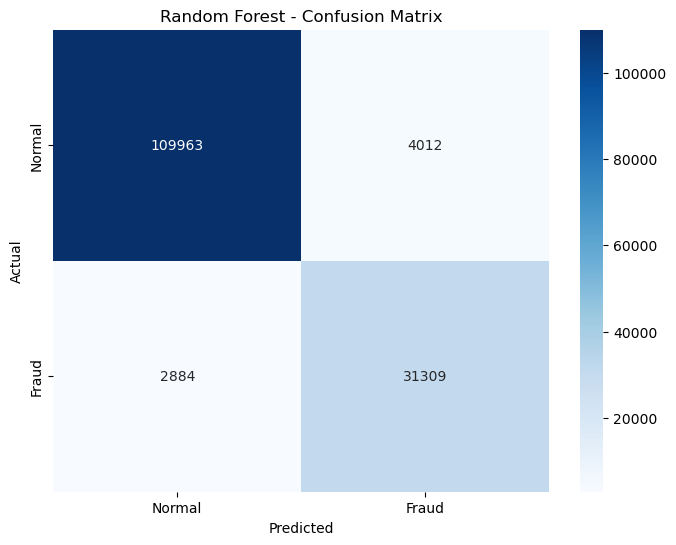

In [14]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    verbose=1
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)
print("Random Forest trained!")

# Evaluasi Random Forest
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf, target_names=['Normal', 'Fraud']))

roc_auc_rf = roc_auc_score(y_val, y_pred_proba_rf)
print(f"\nROC-AUC Score: {roc_auc_rf:.4f}")

cm_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

> Training model Random Forest digunakan untuk pembanding atau alternatif dari model XGBoost untuk dicari mana yang lebih baik antara keduanya.

### Train Model - XGBoost

Scale pos weight: 3.33

Training XGBoost

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99    113975
       Fraud       0.96      0.94      0.95     34193

    accuracy                           0.98    148168
   macro avg       0.97      0.97      0.97    148168
weighted avg       0.98      0.98      0.98    148168


ROC-AUC Score: 0.9905


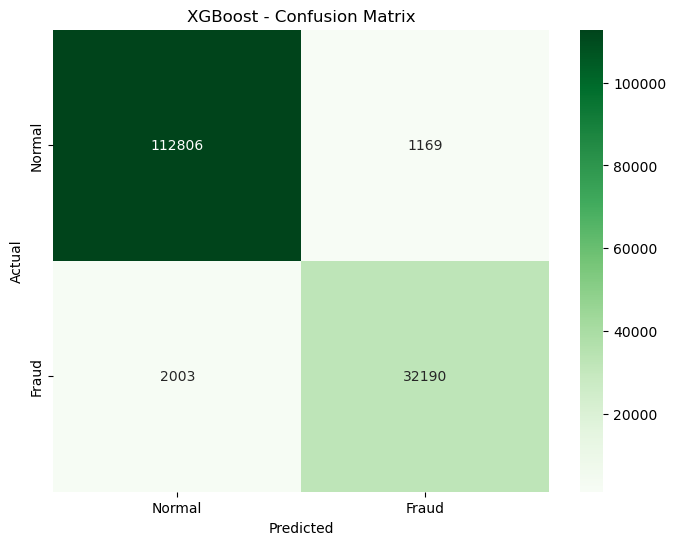

In [15]:
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

xgb_model = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    tree_method='hist',
    eval_metric='logloss',
    verbosity=1
)

print("\nTraining XGBoost")
xgb_model.fit(X_train, y_train)

# Evaluasi XGBoost
y_pred_xgb = xgb_model.predict(X_val)
y_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb, target_names=['Normal', 'Fraud']))

roc_auc_xgb = roc_auc_score(y_val, y_pred_proba_xgb)
print(f"\nROC-AUC Score: {roc_auc_xgb:.4f}")

cm_xgb = confusion_matrix(y_val, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('XGBoost - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

> Training model XGBoost (Extreme Gradient Boosting). XGBoost digunakan karena algoritma tersebut sangat baik untuk tabular data dan structured problems seperti fraud detection.

### Compare Model


All Models Performance:


,ROC-AUC,Precision,Recall,F1-Score
Random Forest,0.979547,0.886413,0.915655,0.900797
XGBoost,0.990462,0.964957,0.941421,0.953044



 BEST MODEL: XGBoost
   ROC-AUC: 0.9905


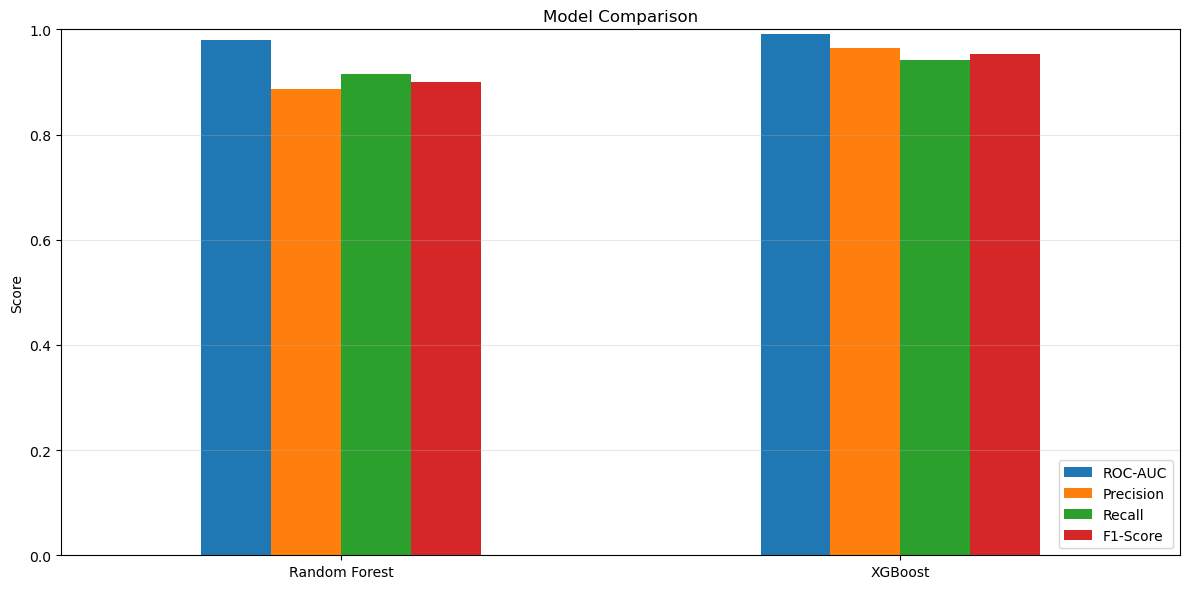

In [16]:
results = {
    'Random Forest': {
        'ROC-AUC': roc_auc_rf,
        'Precision': precision_score(y_val, y_pred_rf),
        'Recall': recall_score(y_val, y_pred_rf),
        'F1-Score': f1_score(y_val, y_pred_rf)
    },
    'XGBoost': {
        'ROC-AUC': roc_auc_xgb,
        'Precision': precision_score(y_val, y_pred_xgb),
        'Recall': recall_score(y_val, y_pred_xgb),
        'F1-Score': f1_score(y_val, y_pred_xgb)
    }
}

results_df = pd.DataFrame(results).T
print("\nAll Models Performance:")
display(results_df)

# Pilih best model
best_model_name = results_df['ROC-AUC'].idxmax()
best_model = xgb_model if best_model_name == 'XGBoost' else rf_model

print(f"\n BEST MODEL: {best_model_name}")
print(f"   ROC-AUC: {results_df.loc[best_model_name, 'ROC-AUC']:.4f}")

# Visualisasi comparison
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### ROC Curve

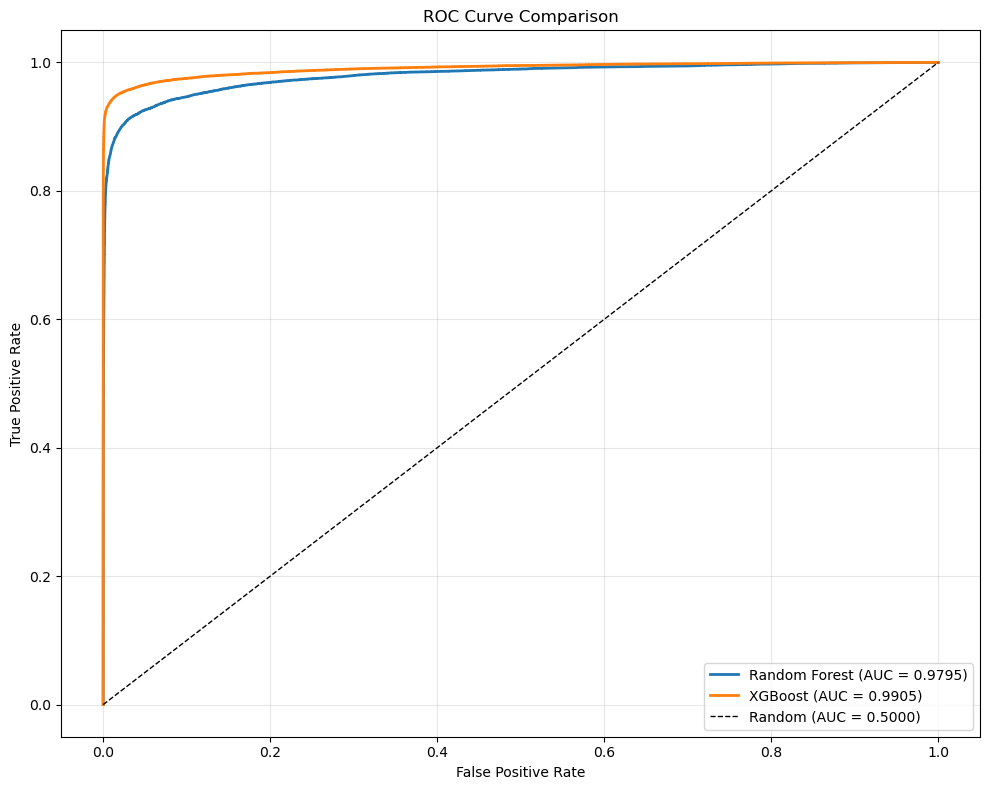

In [17]:
plt.figure(figsize=(10, 8))

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})', linewidth=2)

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})', linewidth=2)

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5000)', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> Code Block ini digunakan untuk memvisualisasi binary klasifikasi model yaitu ROC Curve (Receiver Operating Characteristic).

### Feature Importance


Top 20 Most Important Features:


,Feature,Importance
314,V264,0.172201
315,V265,0.056551
17,C4,0.050620
367,V317,0.042573
268,V218,0.037487
84,V34,0.024884
190,V140,0.020257
356,V306,0.015818
140,V90,0.015737
119,V69,0.015124


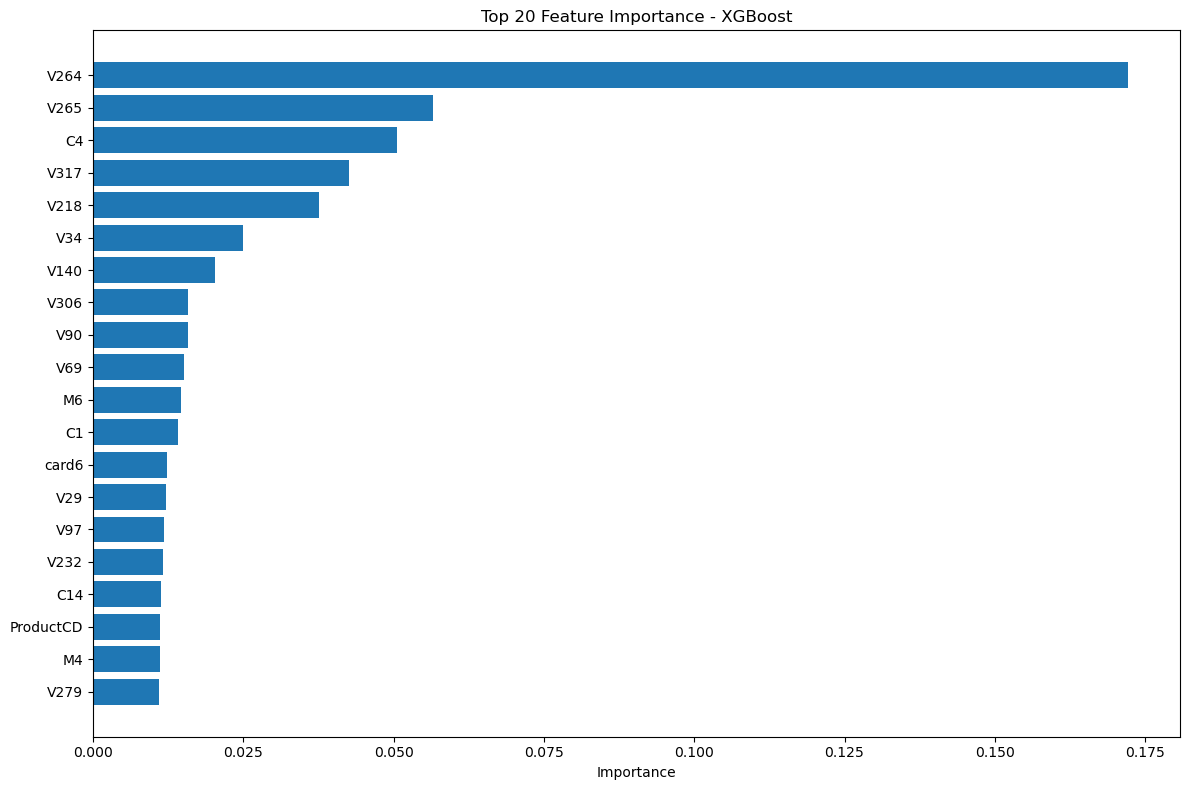

In [18]:
if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
    feature_names = X_train.columns

    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    display(feature_imp_df.head(20))

    plt.figure(figsize=(12, 8))
    top_features = feature_imp_df.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

> Code Block ini digunakan untuk mengekstrak dan memvisualisasikan feature importance dari hasil training XGBoost untuk mencari tau fitur mana yang influential untuk membuat prediksi. Semakin tinggi importance score mengindikasikan fitur tersebut berkontribusi lebih untuk mengurangi kesalahan prediksi.

### Hyperparameter Tuning

In [ ]:
sample_size = 50000
print(f"Using sample of {sample_size} rows for faster tuning...")

sample_idx = np.random.choice(len(X_train), min(sample_size, len(X_train)), replace=False)
X_train_sample = X_train.iloc[sample_idx]
y_train_sample = y_train.iloc[sample_idx]

# Parameter grid LEBIH KECIL
param_grid = {
    'max_depth': [6, 8],
    'learning_rate': [0.1, 0.15],
    'n_estimators': [100, 150]
}

print(f"Total combinations to try: {len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['n_estimators'])}")

grid_search = GridSearchCV(
    xgb.XGBClassifier(random_state=42, tree_method='hist', eval_metric='logloss'),
    param_grid,
    cv=2,
    scoring='roc_auc',
    n_jobs=1,
    verbose=2
)

grid_search.fit(X_train_sample, y_train_sample)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best ROC-AUC: {grid_search.best_score_:.4f}")

# Retrain dengan best params di FULL data
print("\n🔄 Retraining with best params on full data...")
best_params = grid_search.best_params_
best_model = xgb.XGBClassifier(
    **best_params, 
    random_state=42, 
    tree_method='hist', 
    eval_metric='logloss'
)
best_model.fit(X_train, y_train)

print("✅ Model retrained on full data!")

# Evaluate tuned model
y_pred_tuned = best_model.predict(X_val)
y_pred_proba_tuned = best_model.predict_proba(X_val)[:, 1]
roc_auc_tuned = roc_auc_score(y_val, y_pred_proba_tuned)

print(f"\n Tuned Model Performance:")
print(f"   ROC-AUC: {roc_auc_tuned:.4f}")
print(f"   Improvement: {roc_auc_tuned - roc_auc_xgb:.4f}")

Using sample of 50000 rows for faster tuning...
Total combinations to try: 8
Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   3.9s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   4.2s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=150; total time=   4.8s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=150; total time=   5.2s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=100; total time=   5.2s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=100; total time=   5.8s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=150; total time=   6.6s
[CV] END ...learning_rate=0.1, max_depth=8, n_estimators=150; total time=   8.2s
[CV] END ..learning_rate=0.15, max_depth=6, n_estimators=100; total time=   2.9s
[CV] END ..learning_rate=0.15, max_depth=6, n_estimators=100; total time=   2.4s
[CV] END ..learning_rate=0.15, max_depth=6, n_estimat

### Prediction

Using XGBoost for predictions...
Test set size: 506,691

Prediction statistics:
  Mean fraud probability: 0.0393
  Min: 0.0003
  Max: 0.9993
  Median: 0.0100


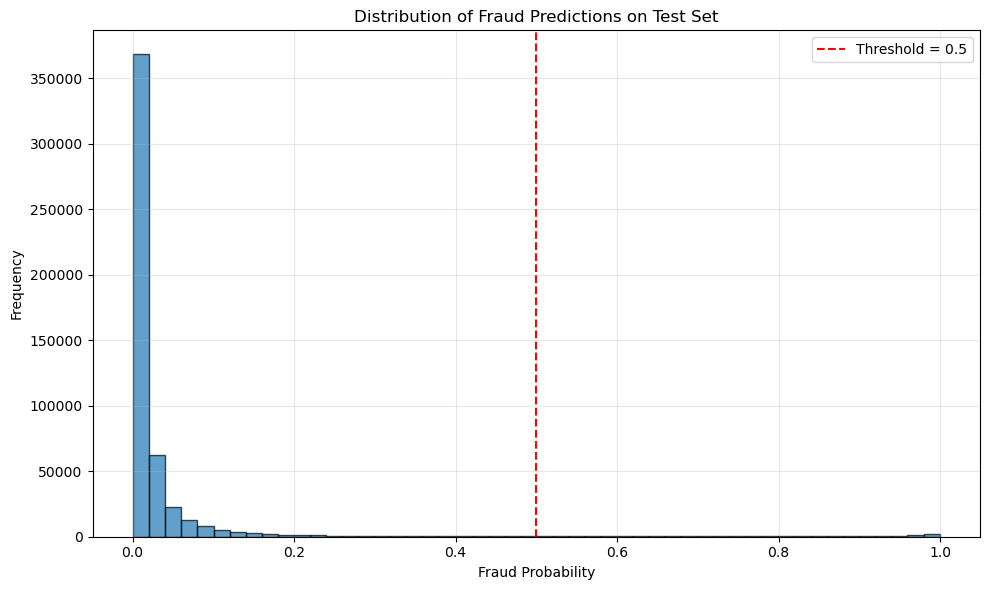


Transactions with >50% fraud probability: 9,365
Transactions with >80% fraud probability: 6,231


In [20]:
print(f"Using {best_model_name} for predictions...")
test_predictions = best_model.predict_proba(test_features)[:, 1]

print(f"Test set size: {len(test_predictions):,}")
print(f"\nPrediction statistics:")
print(f"  Mean fraud probability: {test_predictions.mean():.4f}")
print(f"  Min: {test_predictions.min():.4f}")
print(f"  Max: {test_predictions.max():.4f}")
print(f"  Median: {np.median(test_predictions):.4f}")

# Distribution
plt.figure(figsize=(10, 6))
plt.hist(test_predictions, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Fraud Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Fraud Predictions on Test Set')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTransactions with >50% fraud probability: {(test_predictions > 0.5).sum():,}")
print(f"Transactions with >80% fraud probability: {(test_predictions > 0.8).sum():,}")

> Code Block ini digunakan untuk mencoba model prediksi menggunakan model terbaik yang sudah ditemukan (XGBoost) ke Test Set. Tujuannya untuk mensimulasikan prediksi transaksi fraud.

### Evaluation

In [21]:
print(f"""
Summary:
   - Best Model: {best_model_name}
   - ROC-AUC Score: {results_df.loc[best_model_name, 'ROC-AUC']:.4f}
   - Precision: {results_df.loc[best_model_name, 'Precision']:.4f}
   - Recall: {results_df.loc[best_model_name, 'Recall']:.4f}
   - F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}
   
Dataset Info:
   - Original train size: {len(y):,}
   - After SMOTE: {len(y_resampled):,}
   - Final features: {X_train.shape[1]}
   - Test predictions: {len(test_predictions):,}
   """)


Summary:
   - Best Model: XGBoost
   - ROC-AUC Score: 0.9905
   - Precision: 0.9650
   - Recall: 0.9414
   - F1-Score: 0.9530
   
Dataset Info:
   - Original train size: 590,540
   - After SMOTE: 740,840
   - Final features: 397
   - Test predictions: 506,691
   


> Code Block ini digunakan untuk menampilkan hasil dari training perbandingan antara XGBoost dan Random Forest. Ditemukan XGBoost model memiliki performa lebih baik dibandingkan Random Forest.